In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from tools.data_cleansing import remove_numbers_and_ponctuation, remove_stopwords, remove_non_english_words
from tools.data_exploration import print_email_by_id, emails_sent_distribution, emails_received_distribution,\
body_length_distribution, number_of_recipients_distribution
from tools.data_handling import enrich_emails, load_email_senders, unique_recipients, address_book
from tools.evaluation import precision
from tools.features import bag_of_words, bag_of_emails

# Data loading and first look

In [2]:
df_emails = enrich_emails()
df_emails.head()

,date,body,recipients,sender
mid,,,,
60,2000-07-25 08:14:00,Legal has been assessing the risks of doing bl...,robert.badeer@enron.com murray.o neil@enron.co...,christian.yoder@enron.com
66,2000-08-03 02:56:00,Attached is a spreadsheet to estimate export f...,kim.ward@enron.com robert.badeer@enron.com mur...,heather.dunton@enron.com
74,2000-08-15 05:37:00,Kevin/Bob: Here is a quick rundown on the cons...,robert.badeer@enron.com john.massey@enron.com ...,janel.guerrero@enron.com
80,2000-08-20 14:12:00,check this out and let everyone know what s up...,robert.badeer@enron.com jeff.richter@enron.com,tim.belden@enron.com
83,2000-08-22 08:17:00,Further to your letter to us (addressed to Mr....,pgillman@schiffhardin.com kamarlantes@calpx.co...,christian.yoder@enron.com


In [3]:
print_email_by_id(df_emails, 41311)

From: lynn.blair@enron.com 
To: john.buchanan@enron.com lynn.blair@enron.com
On: 2001-07-26 08:02:34 
Body:
 		John, would you please work with Brad Holmes and Jerry Medeles to capture all of	the system enhancements we have made on NNG since last years meeting.	Thanks. Lynn


# Data exploration

In [4]:
df_email_senders = load_email_senders()

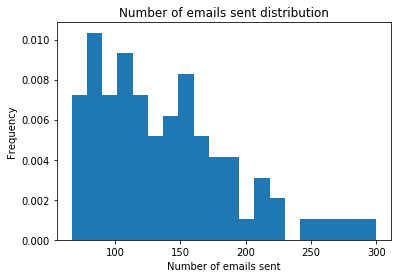

In [5]:
emails_sent_distribution(df_email_senders, max_value=300)

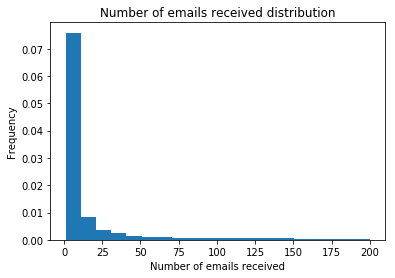

In [6]:
emails_received_distribution(df_emails, max_value=200)

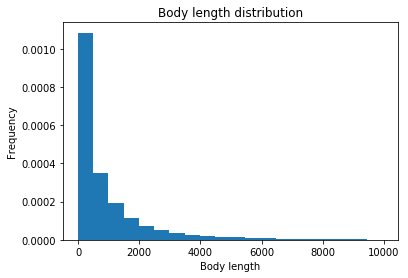

In [7]:
body_length_distribution(df_emails, max_value=10000)

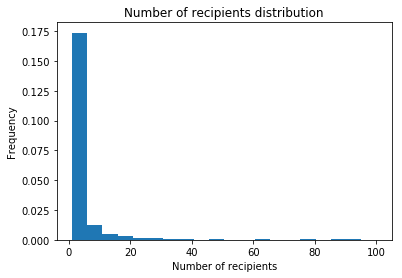

In [8]:
number_of_recipients_distribution(df_emails, bins=20, max_value=100)

In [9]:
unique_rec = unique_recipients(df_emails)
print("Number of unique recipients: {}".format(len(unique_rec)))

Number of unique recipients: 9779


# Dataset separation

In [10]:
df_train = df_emails.sample(n=1000,random_state=42)
train_ids = list(df_train.index.values)
train_mask = df_emails.index.isin(train_ids)
df_test = df_emails[train_mask].sample(n=1000,random_state=42)

# Feature engineering

## Input variables

### Data cleansing

In [11]:
s_text_train = df_train["body"]
unique_rec_train = unique_recipients(df_train)
address_book = address_book(unique_rec_train)
s_text_n_ponct_train = remove_numbers_and_ponctuation(s_text_train)
s_text_n_stop_train = remove_stopwords(s_text_n_ponct_train)
s_text_english_train = remove_non_english_words(s_text_n_stop_train, address_book=address_book)

In [12]:
s_text_test = df_test["body"]
s_text_n_ponct_test = remove_numbers_and_ponctuation(s_text_test)
s_text_n_stop_test = remove_stopwords(s_text_n_ponct_test)
s_text_english_test = remove_non_english_words(s_text_n_stop_test, address_book=address_book)

### BoW computation

In [13]:
X_train, input_bow = bag_of_words(s_text_english_train)

In [14]:
X_test = input_bow.transform(s_text_english_test)

## Output variables

In [15]:
s_recipient = df_train["recipients"]
Y_train, output_bow = bag_of_emails(s_recipient, unique_rec_train)

# Classification

In [16]:
from sklearn.ensemble import RandomForestClassifier

In [17]:
rf = RandomForestClassifier(n_estimators=10, max_depth=500)

In [18]:
rf.fit(X_train, Y_train.toarray())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=500, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [19]:
Y_test = rf.predict(X_test)

## Decoding

In [22]:
top = 10
best_pred_idx = np.argpartition(-Y_test, top, axis=1)[:,:top]
sorted_ids = np.argsort(Y_test[np.arange(Y_test.shape[0])[:, None], best_pred_idx])[:,::-1]
sorted_idx = best_pred_idx[np.arange(best_pred_idx.shape[0])[:, None], sorted_ids]

In [23]:
recipients_map = output_bow.get_feature_names()

In [24]:
df_test["predictions"] = ""

In [25]:
for index, row in df_test.iterrows():
    i = df_test.index.get_loc(index)
    rec_ids = sorted_idx[i, :]
    rec_pred = " ".join([recipients_map[rec_id] for rec_id in rec_ids])
    df_test.set_value(index, "predictions", rec_pred)

# Evaluation

In [26]:
df_test

,date,body,recipients,sender,predictions
mid,,,,,
190995,2001-10-22 06:58:39,23.51,richard.shapiro@enron.com,james.d.steffes@enron.com,michael.robison@enron.com michael.roan@enron.c...
288499,2001-01-25 02:59:00,"For future months, please add Bruce Mills to t...",tiffany.miller@enron.com,phillip.m.love@enron.com,michael.robison@enron.com michael.roan@enron.c...
288570,2001-02-02 10:23:00,FYI---------------------- Forwarded by Phillip...,b.palmer@enron.com victor.guggenheim@enron.com...,phillip.m.love@enron.com,andres.balmaceda@enron.com victor.guggenheim@e...
265398,2001-04-17 11:49:00,Attached is a Conversion/Name Change for GATX ...,colette.weinreich@enron.com samuel.schott@enro...,cheryl.johnson@enron.com,robert.cotten@enron.com sylvia.pollan@enron.co...
175880,2001-04-24 00:31:00,Great idea!John Long04/24/2001 06:04 AMTo: Sta...,john.long@enron.com,stanley.horton@enron.com,john.long@enron.com michael.roan@enron.com mic...
268191,2001-04-13 18:45:00,X-FileName: holden salisbury 6-26-02.PSTSorry ...,amy.fitzpatrick@enron.com portland.desk@enron.com,grace.rodriguez@enron.com,michael.robison@enron.com michael.roan@enron.c...
238221,2001-01-09 00:23:00,Eric - Gerald is forwarding the Calpine contra...,barry.tycholiz@enron.com eric.ledain@enron.com...,stephanie.miller@enron.com,eric.ledain@enron.com kevin.heal@enron.com bar...
186537,2000-04-12 07:39:00,"Sara,Have you been able to locate a copy?Thank...",susan.flynn@enron.com sara.shackleton@enron.com,sheila.glover@enron.com,sara.shackleton@enron.com susan.flynn@enron.co...
362985,2000-08-08 03:57:00,That was very nice. Where do you get this stuf...,mmolloy@oebi.com,chris.dorland@enron.com,mmolloy@oebi.com michael.roan@enron.com michae...


In [28]:
def prec(row):
    return precision(row["predictions"], row["recipients"])
df_test["precision"] = df_test.apply(prec, axis=1)

In [29]:
df_test["precision"].mean(axis=0)

0.7359888888888888